#**PROGRAMMING ASSIGNMENT 2: TEXT CLASSIFICATION**
##QUESTION 1 : CYBERBULLYING CLASSIFICATION

####**Problem Statement :**
####Analysize and Create a multiclassification model to predict cyberbullying type among 6 categories.









####**Data Set :** 
The statistics of cyberbullying are outright alarming: 36.5% of middle and high school students have felt cyberbullied and 87% have observed cyberbullying, with effects ranging from decreased academic performance to depression to suicidal thoughts.

####In light of all of this, this dataset contains more than 47000 tweets labelled according to the class of cyberbullying:


*   Age
*   Ethnicity

*   Gender
*   Religion

*   Other type of cyberbullying
*   Not cyberbullying

####The data has been balanced in order to contain ~8000 of each class.



####**Link to dataset :** https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classific

###Import Libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Model
import re
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

###Load Cyberbullying Dataset

In [7]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d andrewmvd/cyberbullying-classification

  0% 0.00/2.82M [00:00<?, ?B/s]
100% 2.82M/2.82M [00:00<00:00, 182MB/s]


In [9]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cyberbullying-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

###Split into Training and Test data

In [71]:
cybd = pd.read_csv('cyberbullying_tweets.csv')

In [11]:
cybd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [12]:
cybd.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [15]:
cybd.shape

(47692, 2)

In [13]:
cybd['cyberbullying_type'].value_counts()



religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

<Axes: ylabel='cyberbullying_type'>

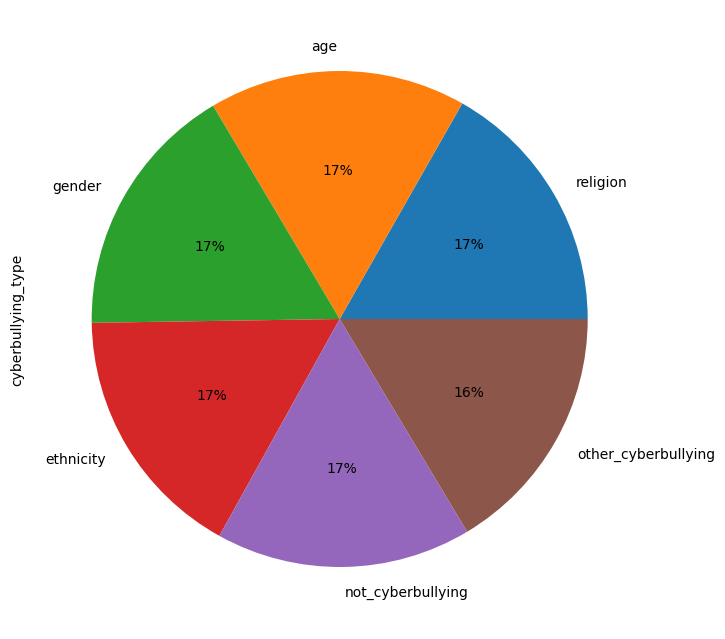

In [94]:
plt.figure(figsize=[8, 10])
cybd["cyberbullying_type"].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [16]:
labels = cybd['cyberbullying_type'].values

In [17]:
labels

array(['not_cyberbullying', 'not_cyberbullying', 'not_cyberbullying', ...,
       'ethnicity', 'ethnicity', 'ethnicity'], dtype=object)

In [18]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    
    # Remove URLs, mentions, and hashtags from the text
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    
    # Join the words back into a string
    text = ' '.join(words)
    return text

In [26]:
cybd['tweet_text'] = cybd['tweet_text'].apply(clean_text)

In [27]:
le = LabelEncoder()
cybd['cyberbullying_type'] = le.fit_transform(cybd['cyberbullying_type'])

In [28]:
cybd_train, cybd_test = train_test_split(cybd, test_size=0.2, random_state=42)
x_train =cybd_train['tweet_text']
y_train =cybd_train['cyberbullying_type']
x_test = cybd_test['tweet_text']
y_test = cybd_test['cyberbullying_type']

In [29]:
sent_lens=[]
for sent in cybd['tweet_text']:
    sent_lens.append(len(word_tokenize(sent)))      
max(sent_lens)

492

In [31]:
np.quantile(sent_lens,0.95)

28.0

In [33]:
max_len = 28

In [34]:
tok = Tokenizer(char_level=False, split=' ')

In [35]:
tok.fit_on_texts(x_train)

In [36]:
vocab_size = len(tok.index_word.keys())
print(vocab_size)


50596


In [58]:
twt = tok.texts_to_sequences(['Muslim'])
print (twt)

[[25]]


In [62]:
twt = tok.texts_to_sequences(['virus'])
print (twt)

[[1250]]


In [60]:
twt = tok.texts_to_sequences(['girl'])
print (twt)

[[23]]


In [37]:
# Convert to numeric sequence
sequences_train = tok.texts_to_sequences(x_train)
# Pad sequences
sequences_matrix_train = sequence.pad_sequences(sequences_train, maxlen = max_len)
# Convert to numeric sequence
sequences_test = tok.texts_to_sequences(x_test)
# Pad sequences
sequences_matrix_test = sequence.pad_sequences(sequences_test, maxlen = max_len)

In [38]:
# Convert labels to categorical form
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [39]:
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    
    # This layer can only be used as the first layer in a model.
    # Turns positive integers (index values) into dense vectors of fixed size.
    # The model will take as input an integer matrix of size (batch, input_length) and the 
    # largest integer (i.e. word index) in the input should be not larger than vocabulary_size+1.  
    # Now model's output_shape is (None, max_len, output_dim), where `None` is the batch dimension. 
    layer = Embedding(input_dim = vocab_size+1, output_dim = 500, input_length = max_len, mask_zero=True)(inputs)
 

    layer = LSTM(64)(layer)   
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(6, name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [40]:
model = RNN()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28)]              0         
                                                                 
 embedding (Embedding)       (None, 28, 500)           25298500  
                                                                 
 lstm (LSTM)                 (None, 64)                144640    
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 6)                 1542  

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
model.fit(sequences_matrix_train, y_train, batch_size=100,epochs=12, 
        validation_data = (sequences_matrix_test, y_test))


Epoch 1/12
382/382 [==============================] - 252s 660ms/step - loss: 0.2264 - accuracy: 0.9112 - val_loss: 0.4599 - val_accuracy: 0.8326
Epoch 2/12
382/382 [==============================] - 249s 651ms/step - loss: 0.1407 - accuracy: 0.9416 - val_loss: 0.5678 - val_accuracy: 0.8179
Epoch 3/12
382/382 [==============================] - 248s 649ms/step - loss: 0.1002 - accuracy: 0.9522 - val_loss: 0.7084 - val_accuracy: 0.8177
Epoch 4/12
382/382 [==============================] - 249s 652ms/step - loss: 0.0820 - accuracy: 0.9562 - val_loss: 0.8382 - val_accuracy: 0.8038
Epoch 5/12
382/382 [==============================] - 248s 649ms/step - loss: 0.0715 - accuracy: 0.9609 - val_loss: 0.9877 - val_accuracy: 0.8087
Epoch 6/12
382/382 [==============================] - 251s 656ms/step - loss: 0.0644 - accuracy: 0.9628 - val_loss: 1.0842 - val_accuracy: 0.8077
Epoch 7/12
382/382 [==============================] - 251s 656ms/step - loss: 0.0609 - accuracy: 0.9639 - val_loss: 1.0871 -

In [64]:
from sklearn.metrics import roc_auc_score
predictions = model.predict(sequences_matrix_test)
roc_auc_score(y_test,predictions)

299/299 [==============================] - 6s 19ms/step


0.9456412358075191

In [61]:
index=99 
review = sequences_test[index]
review_words =[]
for k in review:
 review_words.append((tok.index_word[k]))
review_words  

['racists',
 'idiots',
 'believe',
 'please',
 'ask',
 'muslim',
 'go',
 'mosque',
 'mosques',
 'probably',
 'one',
 'guidelines',
 'virus',
 'country',
 'enter',
 'criteria']

In [104]:
pred = model.predict(sequences_matrix_test[index].reshape(1,28))
print(labels[np.argmax(pred)])

1/1 [==============================] - 0s 37ms/step
not_cyberbullying


In [49]:
labels[np.argmax(y_test[index])]

'not_cyberbullying'

##QUESTION 2 : FINANCIAL SENTIMENT ANALYSIS

####**Problem Statement :**
####Create a multiclassification model to analyze and predict sentiments of texts/ comments related to finance.


####**Data Set :** 
####The following data is intended for advancing financial sentiment analysis research. It's two datasets (FiQA, Financial PhraseBank) combined into one easy-to-use CSV file. It provides financial sentences with sentiment labels:

*   Positive
*   Negative

*   Neutral

####**Link to dataset :** https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis


In [105]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional

In [68]:
!kaggle datasets download -d sbhatti/financial-sentiment-analysis

  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 65.9MB/s]


In [69]:
import zipfile
zip_ref = zipfile.ZipFile('/content/financial-sentiment-analysis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [75]:
fsa = pd.read_csv('data.csv')

In [76]:
fsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [77]:
fsa.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [78]:
fsa.shape

(5842, 2)

In [79]:
fsa['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

<Axes: ylabel='Sentiment'>

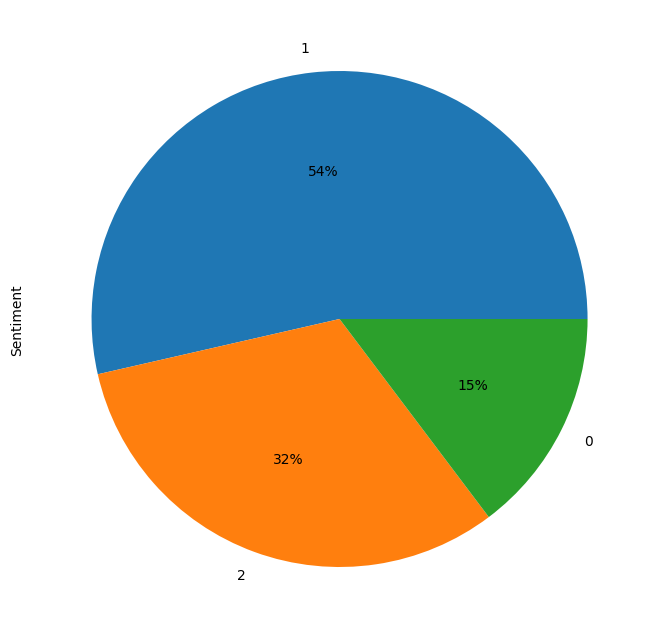

In [95]:
plt.figure(figsize=[8, 10])
fsa["Sentiment"].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [83]:
labels2 = fsa['Sentiment'].values
labels2

array(['positive', 'negative', 'positive', ..., 'neutral', 'neutral',
       'positive'], dtype=object)

In [90]:
def clean_text2(text2):
    # Remove HTML tags
    text2 = re.sub('<.*?>', '', text2)
    
    # Remove non-alphabetic characters and convert to lowercase
    text2 = re.sub('[^a-zA-Z]', ' ', text2).lower()
    
    # Remove URLs, mentions, and hashtags from the text
    text2 = re.sub(r'http\S+', '', text2)
    text2 = re.sub(r'@\S+', '', text2)
    text2 = re.sub(r'#\S+', '', text2)
    
    # Tokenize the text
    words2 = nltk.word_tokenize(text2)
    
    # Remove stopwords
    words2 = [w for w in words2 if w not in stopwords.words('english')]
    
    # Join the words back into a string
    text2 = ' '.join(words2)
    return text2

In [91]:
fsa['Sentence'] = fsa['Sentence'].apply(clean_text2)

In [92]:
le2 = LabelEncoder()
fsa['Sentiment'] = le2.fit_transform(fsa['Sentiment'])

In [96]:
y = to_categorical(fsa['Sentiment'])
x = fsa['Sentence']
X_train2,X_test2, y_train2,y_test2 = train_test_split(x,y,test_size=0.3,stratify=y,random_state=42)

In [97]:
num_words = 12000 
tokenizer=Tokenizer(num_words,lower=True)
fsa_total = pd.concat([pd.Series(X_train2), pd.Series(X_test2)], axis = 0)
tokenizer.fit_on_texts(fsa_total)

In [99]:
X_train_ =tokenizer.texts_to_sequences(X_train2)
X_train_pad=pad_sequences(X_train_,maxlen=81,padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test2)
X_test_pad = pad_sequences(X_test_, maxlen = 81, padding = 'post')

In [107]:
lstm = Sequential()
lstm.add(Embedding(input_dim = num_words,
                          output_dim = 100,
                          input_length= X_train_pad.shape[1]))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(256,return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(128,return_sequences=False)))
lstm.add(Dense(64,activation='tanh'))
lstm.add(Dense(32,activation='tanh'))
lstm.add(Dense(10,activation='tanh'))
lstm.add(Dense(3,activation='softmax'))

In [108]:
lstm.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [109]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 81, 100)           1200000   
                                                                 
 dropout_8 (Dropout)         (None, 81, 100)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 81, 256)          234496    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 81, 256)           0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 81, 512)          1050624   
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 81, 512)          

In [111]:
lstm_history = lstm.fit(X_train_pad,y_train2, epochs = 10, batch_size = 64, validation_data=(X_test_pad, y_test2),verbose = 1)

Epoch 1/10
64/64 [==============================] - 180s 3s/step - loss: 0.9318 - accuracy: 0.5679 - val_loss: 0.8374 - val_accuracy: 0.6463
Epoch 2/10
64/64 [==============================] - 170s 3s/step - loss: 0.6787 - accuracy: 0.7281 - val_loss: 0.7759 - val_accuracy: 0.6794
Epoch 3/10
64/64 [==============================] - 166s 3s/step - loss: 0.4203 - accuracy: 0.8403 - val_loss: 0.7871 - val_accuracy: 0.6783
Epoch 4/10
64/64 [==============================] - 192s 3s/step - loss: 0.2833 - accuracy: 0.8826 - val_loss: 0.8768 - val_accuracy: 0.6726
Epoch 5/10
64/64 [==============================] - 172s 3s/step - loss: 0.2279 - accuracy: 0.8995 - val_loss: 0.9917 - val_accuracy: 0.6640
Epoch 6/10
64/64 [==============================] - 178s 3s/step - loss: 0.2018 - accuracy: 0.9073 - val_loss: 1.0220 - val_accuracy: 0.6458
Epoch 7/10
64/64 [==============================] - 178s 3s/step - loss: 0.1941 - accuracy: 0.9080 - val_loss: 1.1069 - val_accuracy: 0.6515
Epoch 8/10
64

In [114]:
index=90

In [115]:
X_test_[index]


[363, 3034, 356, 4864, 1974, 232]

In [117]:
pred2 = lstm.predict(X_test_pad[index].reshape(1,81))
print(labels2[np.argmax(pred2)])

1/1 [==============================] - 0s 72ms/step
positive


In [118]:
labels2[np.argmax(y_test2[index])]

'positive'